In [18]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [58]:
# Simple coordinate reader for xyz files. Will run for single structure xyz files and trajectories.

def read_coordinate(xyz_file, atom_list):

    with open(xyz_file, 'r') as file:
        lines = file.readlines()
        no_atoms = int(lines[0])
        coordinate_list = []
        
        i = 0
        
        while i != len(lines):
            segment = lines[i:i+no_atoms+2][2:]
            segment = [line.split()[1:4] for line in segment]
            coordinate_list.append(np.array(segment).astype(float))
            
            i = i + no_atoms + 2
            
        file.close()
        
    def read_distances(coordinate_list, atom1,atom2):

        distances = []

        for n in range(len(coordinate_list)):
            dX = coordinate_list[n][atom1 - 1][0] - coordinate_list[n][atom2 - 1][0]
            dY = coordinate_list[n][atom1 - 1][1] - coordinate_list[n][atom2 - 1][1]
            dZ = coordinate_list[n][atom1 - 1][2] - coordinate_list[n][atom2 - 1][2]

            d = np.sqrt(dX**2 + dY**2 + dZ**2)

            d = float("{:.5f}".format(d)) # Round to 5 decimal places (Matches GaussView)

            distances.append(d)

        return distances

    def read_angles(coordinate_list, atom1, atom2, atom3):

        rad2deg_ = 180 / np.pi
        angles = []

        for n in range(len(coordinate_list)): 

            x1 = coordinate_list[n][atom1 - 1][0] - coordinate_list[n][atom2 - 1][0]
            y1 = coordinate_list[n][atom1 - 1][1] - coordinate_list[n][atom2 - 1][1]
            z1 = coordinate_list[n][atom1 - 1][2] - coordinate_list[n][atom2 - 1][2]

            x2 = coordinate_list[n][atom3 - 1][0] - coordinate_list[n][atom2 - 1][0]
            y2 = coordinate_list[n][atom3 - 1][1] - coordinate_list[n][atom2 - 1][1]
            z2 = coordinate_list[n][atom3 - 1][2] - coordinate_list[n][atom2 - 1][2]

            dot = (x1 * x2) + (y1 * y2) + (z1 * z2)

            mag1 = np.sqrt(x1**2 + y1**2 + z1**2)
            mag2 = np.sqrt(x2**2 + y2**2 + z2**2)

            angle = np.arccos(dot / (mag1 * mag2)) * rad2deg_
            angle = float("{:.5f}".format(angle))

            angles.append(angle)

        return angles

    def read_dihedrals(coordinate_list, atom1, atom2, atom3, atom4):

        dihedrals = []

        for n in range(len(coordinate_list)):     

            A = coordinate_list[n][atom1 - 1]
            B = coordinate_list[n][atom2 - 1]
            C = coordinate_list[n][atom3 - 1]
            D = coordinate_list[n][atom4 - 1]

            AB = B - A
            BC = C - B
            CD = D - C

            N1 = np.cross(AB, BC)
            N2 = np.cross(BC, CD)

            N1 /= np.linalg.norm(N1)
            N2 /= np.linalg.norm(N2)

            cos_theta = np.dot(N1, N2)
            angle = np.arccos(cos_theta)

            m = np.cross(N1, N2)
            sign = np.dot(m, BC / np.linalg.norm(BC))
            if sign < 0:
                angle = -angle

            angle_degrees = float("{:.5f}".format(np.degrees(angle)))

            dihedrals.append(angle_degrees)

        return dihedrals
    
    if len(atom_list) == 1:
        
        positions = []
        
        for n in range(len(coordinate_list)):
            
            x = tuple([coordinate_list[n][atom_list[0] - 1][0], coordinate_list[n][atom_list[0] - 1][1], coordinate_list[n][atom_list[0] - 1][2]])
            positions.append(x)
            
        return positions
    
    if len(atom_list) == 2:
        return read_distances(coordinate_list, atom_list[0], atom_list[1])
    
    if len(atom_list) == 3:
        return read_angles(coordinate_list, atom_list[0], atom_list[1], atom_list[2])
    
    if len(atom_list) == 4:
        return read_dihedrals(coordinate_list, atom_list[0], atom_list[1], atom_list[2], atom_list[3])
    
    if len(atom_list) > 4:
        raise ValueError('You have specified too many atoms')

def plot_traj(xyz_file, timestep, var_name='colvar'):
    
    colvar = read_coordinate(xyz_file, [8, 7, 16])

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11,3), width_ratios=[3.5,1])

    time = [i / (1/timestep) for i in range(len(colvar))] # Timestep = 0.25 ps

    ax1.plot(time, colvar, linewidth=0.2)
    ax1.set_xlabel(f"time (ps); stepsize = {timestep}ps")
    ax1.set_ylabel(var_name)
    ax1.set_title(f"file: {xyz_file}", fontsize = 10)

    midpt = int(np.round(len(colvar) / 2))


    ax2.hist(colvar[0:midpt], bins='rice', fc=(0, 0, 1, 0.3), orientation="horizontal") # First half shown in blue
    ax2.hist(colvar[midpt:-1], bins='rice', fc=(0, 0, 1, 0.5), orientation="horizontal") # Second half shown in red
    # ax2.axhline(y=np.average(colvar), color='b', linewidth=2)
    
    ax2.set_title(f"average = {np.round(np.average(colvar), 3)}", fontsize = 10)

    ax2.set_xlabel('structures')

    plt.tight_layout()
    
    return

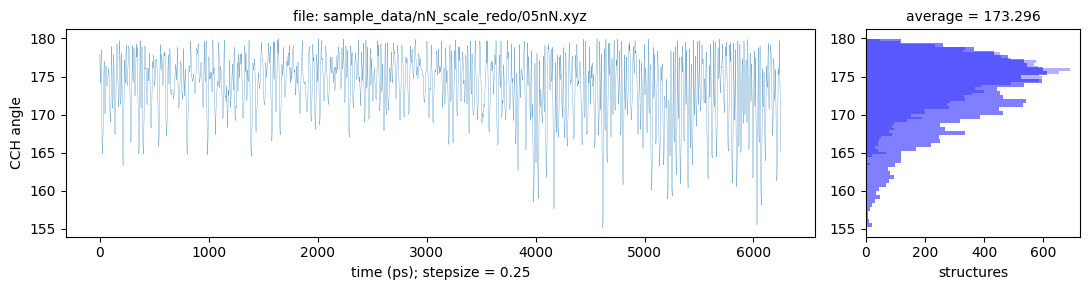

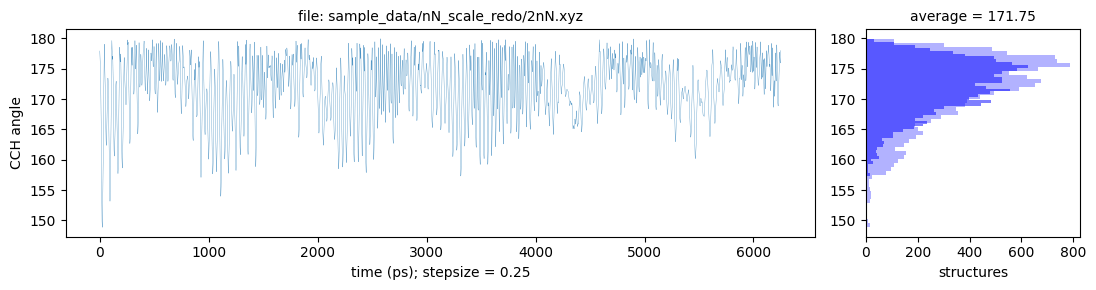

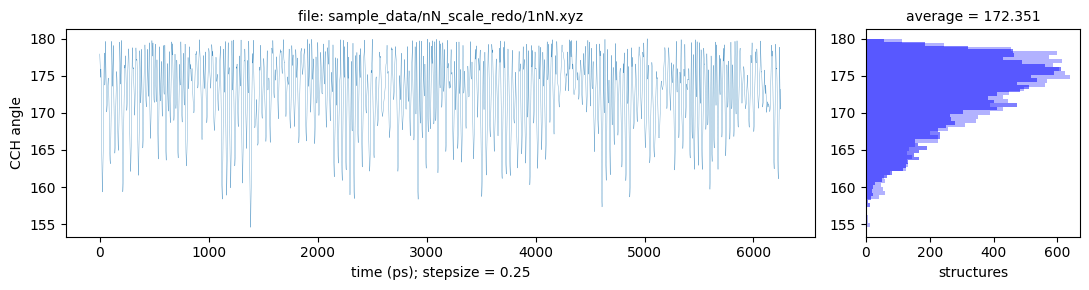

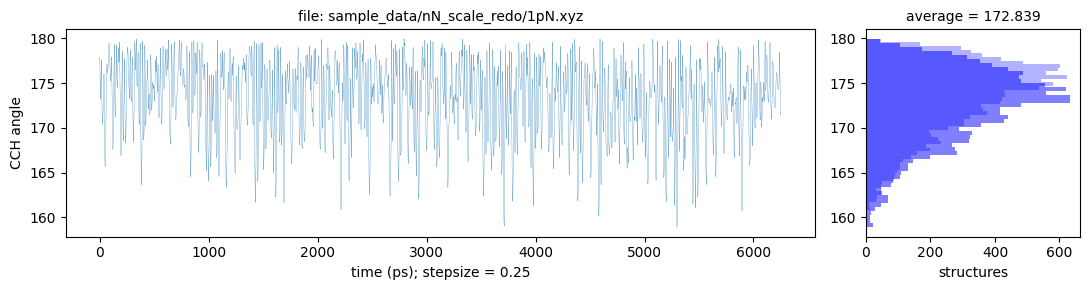

In [61]:
# plot_traj('sample_data/nN_scale_redo/1nN.xyz', 0.25)

wdir = 'sample_data/nN_scale_redo/'

for file in os.listdir(wdir):
    plot_traj(f"{wdir}{file}", 0.25, 'CCH angle')